In [3]:
import keras

### Tuodaan kuvat kansiosta ja muodostetaan dataset


In [3]:
batch_size = 32
img_size = (224, 224)

train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
    'CIFAR-IMAGES/train',
    batch_size=batch_size, 
    image_size=img_size,
    label_mode='categorical',
    validation_split=0.2, 
    subset='both',
    seed=123123)

test_dataset = keras.utils.image_dataset_from_directory(
    'CIFAR-IMAGES/test',
    batch_size=batch_size, 
    image_size=img_size,
    label_mode='categorical')

# Print the first taining image's first channel
print(train_dataset.take(1).get_single_element()[0][0][0][0])

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Using 10000 files for validation.
Found 10000 files belonging to 10 classes.
tf.Tensor([128. 172. 121.], shape=(3,), dtype=float32)


### Otetaan esikoulutettu malli ja tarkastellaan sitä
Valitsin VGG16 -mallin koska se on ilmeisesti sopiva kuvien tarkasteluun

In [4]:
from keras.applications import VGG16

VGG16_model = VGG16(include_top=False)
VGG16_model.trainable = False
VGG16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Esikäsittely
VGG 16 tarvitsee kuvat tietyssä muodossa. Onneksi malli tarjoaa esikäsittelyyn soveltuvan funktion.

Testataan aluksi funktiota pieneen määrään ja katsotaan tulos

In [5]:
from keras.applications.vgg16 import preprocess_input


# Take a small batch from the training dataset
small_batch = train_dataset.take(1)

# Extract the images (x) from the batch
for images, labels in small_batch:
    break  # Get the first batch

preprocessed_images = preprocess_input(images)

# Run the small batch through the pretrained model
test_features = VGG16_model.predict(preprocessed_images)

# Print the shape of the output
print("Shape of extracted features:", test_features.shape)

# Optionally, inspect the feature values
print("Sample feature values:", test_features[0, :5, :5, 0])  # Print a small slice

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
Shape of extracted features: (32, 7, 7, 512)
Sample feature values: [[0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        2.658058  0.       ]
 [0.        0.        0.        5.8831825 5.4482813]]


VGG 16 esikäsittely ottaa kuvan ja muuttaa sen RGB -muodosta BRG -muotoon ja tasoittaa väriarvoja.

Jatketaan esikäsittely koko datasetille ja kerätään featuret datasetistä VGG 16 -mallilla.

Mallin ulos annetut featuret tallennetaan muistiin.

In [ ]:
from keras.applications.vgg16 import preprocess_input
import numpy as np
# Edistyksen seuraamiseen, ei olennainen
from tqdm import tqdm

# Funktio, joka käsittelee datasetin ja tuottaa ominaisuudet ja luokkien nimet
def process_dataset(dataset, model, desc="Processing"):
    features_list = []
    labels_list = []
    
    # Get total number of batches for progress tracking
    total_batches = 0
    for _ in dataset:
        total_batches += 1
    
    # Reset the dataset iterator
    dataset = dataset.repeat(1)
    
    # Process with progress bar
    with tqdm(total=total_batches, desc=desc) as pbar:
        for images, labels in dataset:
            # Apply VGG16 preprocessing to each batch
            preprocessed_images = preprocess_input(images)
            # Extract features
            features = model.predict(preprocessed_images, verbose=0, batch_size=32)
            features_list.append(features)
            labels_list.append(labels)
            pbar.update(1)
    
    return np.vstack(features_list), np.vstack(labels_list)


print("Processing training dataset...")
train_features, train_labels = process_dataset(train_dataset, VGG16_model, desc="Training")

print("Processing validation dataset...")
validation_features, validation_labels = process_dataset(validation_dataset, VGG16_model, desc="Validation")

print("Processing test dataset...")
test_features, test_labels = process_dataset(test_dataset, VGG16_model, desc="Test")

# Print the shape to confirm the output dimensions
print("Training features shape:", train_features.shape)
print("Validation features shape:", validation_features.shape)
print("Test features shape:", test_features.shape)

# Save the features to disk
# Save the features and labels to .npy files
np.save('train_features.npy', train_features)
np.save('validation_features.npy', validation_features)
np.save('test_features.npy', test_features)
np.save('train_labels.npy', train_labels)
np.save('validation_labels.npy', validation_labels)
np.save('test_labels.npy', test_labels)

Processing training dataset...


Training: 100%|██████████| 1250/1250 [17:16<00:00,  1.21it/s]


Processing validation dataset...


Validation: 100%|██████████| 313/313 [04:19<00:00,  1.20it/s]


Processing test dataset...


Test: 100%|██████████| 313/313 [04:18<00:00,  1.21it/s]


Training features shape: (40000, 7, 7, 512)
Validation features shape: (10000, 7, 7, 512)
Test features shape: (10000, 7, 7, 512)


In [2]:
import keras
import numpy as np

# Load the features and labels from disk
train_features = np.load('train_features.npy')
validation_features = np.load('validation_features.npy')
test_features = np.load('test_features.npy')
train_labels = np.load('train_labels.npy')
validation_labels = np.load('validation_labels.npy')
test_labels = np.load('test_labels.npy')

### Oma malli
Esikoulutettu malli on nyt käsitellyt datasetin ja käytetään sen antamia featureja

Oma malli on FCC malli, ja koostuu muutamasta Dense layeristä.

In [13]:
# CIFAR 10 classification with pretrained VGG16 features
fullyConnectedClassifier = keras.Sequential([
    keras.layers.InputLayer(shape=(7, 7, 512)),
    keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.002)

fullyConnectedClassifier.compile(optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

fullyConnectedClassifier.summary()
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the classifier
fullyConnectedClassifier.fit(train_features, train_labels,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    validation_data=(validation_features, validation_labels))

# Evaluate the classifier on the test set
test_loss, test_accuracy = fullyConnectedClassifier.evaluate(test_features, test_labels)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,714 (784.04 KB)

 Trainable params: 200,202 (782.04 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5924 - loss: 3.2061 - val_accuracy: 0.6541 - val_loss: 1.3579
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6695 - loss: 1.2738 - val_accuracy: 0.6741 - val_loss: 1.1977
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6875 - loss: 1.1575 - val_accuracy: 0.6356 - val_loss: 1.3508
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6953 - loss: 1.1087 - val_accuracy: 0.6995 - val_loss: 1.0485
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7042 - loss: 1.0511 - val_accuracy: 0.3659 - val_loss: 4.0117
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7107 - loss: 1.0502 - val_accuracy: 0.6998 - val_loss: 1.0448
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7079 - loss: 1.0312 - val_accuracy: 0.7099 - val_loss: 0.9992
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7116 - loss: 1.0111 - 

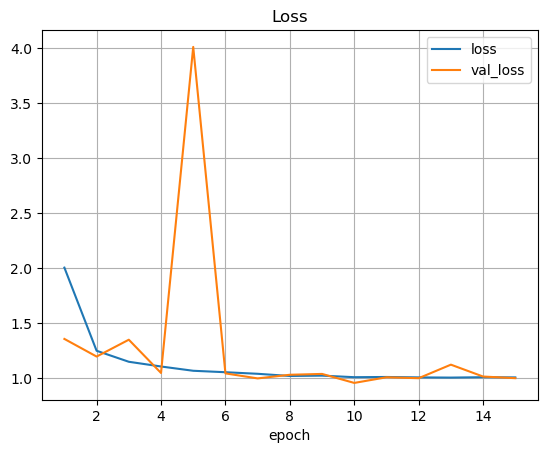

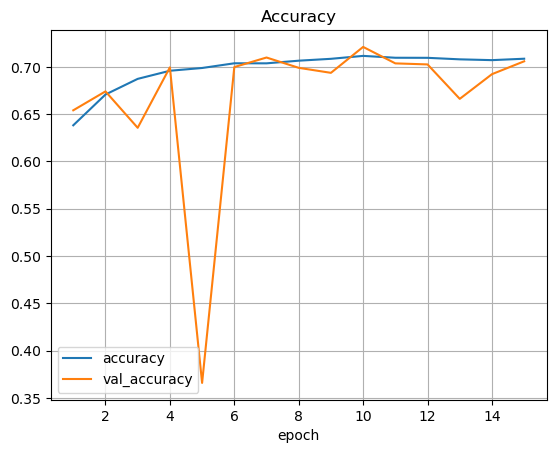

In [14]:
# Graph the training history
import matplotlib.pyplot as plt
import pandas as pd

history = fullyConnectedClassifier.history.history
history_df = pd.DataFrame(history)
history_df['epoch'] = history_df.index + 1
history_df.set_index('epoch', inplace=True)
history_df.plot(y=['loss', 'val_loss'], title='Loss', grid=True)
plt.show()
history_df.plot(y=['accuracy', 'val_accuracy'], title='Accuracy', grid=True)
plt.show()

Aluksi koulutin esikoulutetulla mallilla featuret, mutta oli väärä formaatti. VGG16 vaatii eräänlaisen esiprosessoinnin ennen toimintaa.

Lopuksi kaikki onnistui hyvin. Mallin tuottamat feature -tiedostot ovat suuria, joten niitä ei varmaan kannata laittaa repositorioon.

Omaan luokittelumalliin asetin aluksi liian monta tasoa, ja ne olivat liian suuria. Tämä johti ylioppimiseen. Yksinkertaistin mallia ottamalla siitä kerroksia pois ja pienensin neuronien määrää 512 -> 256.